# Fáza 3 - strojové učenie
## Autori: Matej Delinčák (50%), Martin Pirkovský (50%)

In [190]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from IPython.display import Image
from sklearn.tree import export_graphviz
import graphviz 
from subprocess import call
from pprint import pprint

In [191]:
df = pd.read_csv("merged_dataset.csv", sep=',')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [192]:
df_train, df_test = train_test_split(df, test_size=0.15)

## 1. Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu (5b)

## ALGORITMUS 1R

Algoritmus zahrnujuci 1 pravidlo (čiže jeden stĺpec). Vybrali sme si hbver, pretože v predošlom zadadní nám vyšiel ako najlepší atribút. A budeme mať pravidlo, že ak hbver je väčší ako 0.5 tak pacient bude pravdepodobne zdravý.

$Accuracy = \frac{TP+TN}{TP+FP+FN+TN}$

$Precision = \frac{TP}{TP+FP}$

$Recall = \frac{TP}{TP+FN}$

In [193]:
datas_from_classification = dict()

In [194]:
def print_classf_data(key):
    global datas_from_classification
    
    print("Name:       Values:")
    print()
    print("Total:     ", datas_from_classification[key]["ALL"])
    print("TP:        ", datas_from_classification[key]["TP"])
    print("TN:        ", datas_from_classification[key]["TN"])
    print("FP:        ", datas_from_classification[key]["FP"])
    print("FN:        ", datas_from_classification[key]["FN"])
    
    mat = [[datas_from_classification[key]["TN"],  datas_from_classification[key]["FP"]], [ datas_from_classification[key]["FN"], datas_from_classification[key]["TP"]]]
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

    accuracy = (datas_from_classification[key]["TP"] + datas_from_classification[key]["TN"]) / datas_from_classification[key]["ALL"]
    precision = datas_from_classification[key]["TP"] / (datas_from_classification[key]["FP"] + datas_from_classification[key]["TP"])
    recall = datas_from_classification[key]["TP"] / (datas_from_classification[key]["FN"] + datas_from_classification[key]["TP"])
    print("Accuracy:  ",accuracy)
    print("Precision: ", precision)
    print("Recall:    ", recall)
    print()

AxesSubplot(0.125,0.125;0.775x0.755)


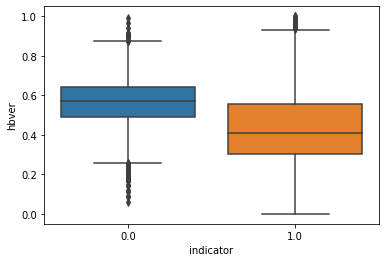

In [195]:
print(sns.boxplot(y="hbver", x="indicator", data=df))

In [196]:
def algorithm1R(df, key):
    global datas_from_classification
    
    datas_from_classification[key] = dict()
    datas_from_classification[key]["ALL"] = len(df)


    datas_from_classification[key]["TP"] = len(df.loc[(df.hbver > 0.5) & (df['indicator'] == 0.0)])
    datas_from_classification[key]["TN"] = len(df.loc[(df.hbver < 0.5) & (df['indicator'] == 1.0)])
    datas_from_classification[key]["FP"] = len(df.loc[(df.hbver > 0.5) & (df['indicator'] == 1.0)])
    datas_from_classification[key]["FN"] = len(df.loc[(df.hbver < 0.5) & (df['indicator'] == 0.0)])

    print_classf_data(key)
    
    datas_from_classification[key]["VALS"] = np.array((df.apply(lambda row: 0.0 if row.hbver > 0.5 else 1.0, axis=1)).values.tolist())
    datas_from_classification[key]["CR"] = classification_report(df['indicator'],datas_from_classification[key]["VALS"], target_names = ["0","1"])
    print(datas_from_classification[key]["CR"])

Name:       Values:

Total:      7058
TP:         1872
TN:         2945
FP:         1508
FN:         733
Accuracy:   0.6824879569283083
Precision:  0.5538461538461539
Recall:     0.7186180422264875

              precision    recall  f1-score   support

           0       0.55      0.72      0.63      2605
           1       0.80      0.66      0.72      4453

    accuracy                           0.68      7058
   macro avg       0.68      0.69      0.67      7058
weighted avg       0.71      0.68      0.69      7058



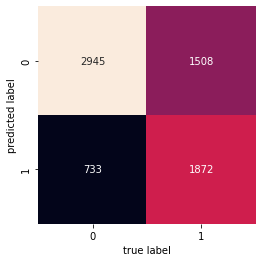

In [197]:
algorithm1R(df_train,"train_1R")

Name:       Values:

Total:      1246
TP:         345
TN:         527
FP:         243
FN:         131
Accuracy:   0.6998394863563403
Precision:  0.5867346938775511
Recall:     0.7247899159663865

              precision    recall  f1-score   support

           0       0.59      0.72      0.65       476
           1       0.80      0.68      0.74       770

    accuracy                           0.70      1246
   macro avg       0.69      0.70      0.69      1246
weighted avg       0.72      0.70      0.70      1246



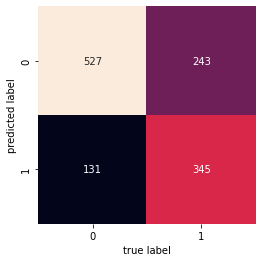

In [198]:
algorithm1R(df_test,"test_1R")

## ALGORITMUS 2R

Algoritmus zahrnujuci 2 pravidlá (čiže dva stĺpce). Vybrali sme si hbver a leukocyty, pretože v predošlom zadadní nám vyšli ako najlepšie. A budeme mať pravidlo, že ak hbver je väčší ako 0.5 a leukocyty viac ako xx, tak pacient bude pravdepodobne zdravý.

<AxesSubplot:xlabel='leukocyty', ylabel='hbver'>

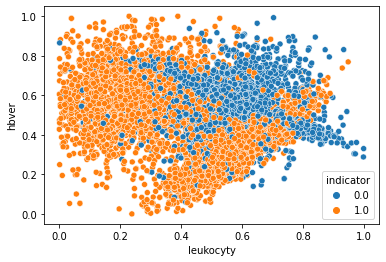

In [199]:
sns.scatterplot(y="hbver", x="leukocyty", hue="indicator", data=df)

In [200]:
def algorithm2R(df, key):
    global datas_from_classification
    
    datas_from_classification[key] = dict()
    datas_from_classification[key]["ALL"] = len(df)


    datas_from_classification[key]["TP"] = len(df.loc[((df.hbver > 0.5) & (df.leukocyty > 0.25)) & (df['indicator'] == 0.0)])
    datas_from_classification[key]["TN"] = len(df.loc[((df.hbver < 0.5) | (df.leukocyty < 0.25)) & (df['indicator'] == 1.0)])
    datas_from_classification[key]["FP"] = len(df.loc[((df.hbver > 0.5) & (df.leukocyty > 0.25)) & (df['indicator'] == 1.0)])
    datas_from_classification[key]["FN"] = len(df.loc[((df.hbver < 0.5) | (df.leukocyty < 0.25)) & (df['indicator'] == 0.0)])

    print_classf_data(key)
    
    datas_from_classification[key]["VALS"] = np.array((df.apply(lambda row: 0.0 if ((row.hbver > 0.5) & (row.leukocyty > 0.25)) else 1.0, axis=1)).values.tolist())
    datas_from_classification[key]["CR"] = classification_report(df['indicator'],datas_from_classification[key]["VALS"], target_names = ["0","1"])
    print(datas_from_classification[key]["CR"])

Name:       Values:

Total:      7058
TP:         1850
TN:         3565
FP:         888
FN:         755
Accuracy:   0.7672145083593086
Precision:  0.6756756756756757
Recall:     0.710172744721689

              precision    recall  f1-score   support

           0       0.68      0.71      0.69      2605
           1       0.83      0.80      0.81      4453

    accuracy                           0.77      7058
   macro avg       0.75      0.76      0.75      7058
weighted avg       0.77      0.77      0.77      7058



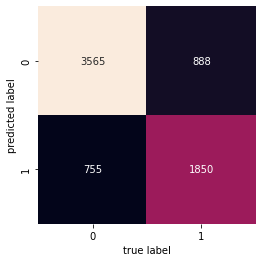

In [201]:
algorithm2R(df_train,"train_2R")

Name:       Values:

Total:      1246
TP:         337
TN:         637
FP:         133
FN:         139
Accuracy:   0.7817014446227929
Precision:  0.7170212765957447
Recall:     0.707983193277311

              precision    recall  f1-score   support

           0       0.72      0.71      0.71       476
           1       0.82      0.83      0.82       770

    accuracy                           0.78      1246
   macro avg       0.77      0.77      0.77      1246
weighted avg       0.78      0.78      0.78      1246



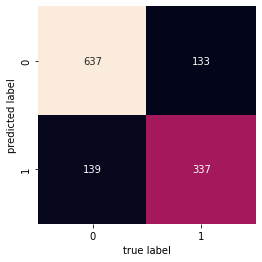

In [202]:
algorithm2R(df_test,"test_2R")

## 2. Natrénovanie a vyhodnotenie klasifikátora strojového učenia (5b)

In [203]:
train_output = df_train['indicator']
test_output = df_test['indicator']

In [204]:
columns = ['age','sex','race','hemoglobin','alt','alp','trombocyty','relationship','ast','weight','indicator']
df_train_class = df_train.drop(columns, axis=1)
df_test_class = df_test.drop(columns, axis=1)

Z celeho datasetu sme vybrali len tie stĺpce, ktoré nám anova dala ako najlepšie  predošlého zadania.

In [205]:
model = RandomForestClassifier().fit(df_train_class, train_output)
predicted_labels = model.predict(df_test_class)

print('Training accuracy: ',model.score(df_train_class,train_output))
print('Test Accuracy: ',model.score(df_test_class, test_output))

Training accuracy:  1.0
Test Accuracy:  0.9365971107544141


In [206]:
export_graphviz(model.estimators_[1], 
                out_file='tree.dot', 
                feature_names=df_test_class.columns,
                class_names = ["0","1"], 
                rounded = True, proportion = False, 
                precision = 2, filled = True)
                            

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])


# Image(filename = 'tree.png')

0

treba vyzualizovat aj strom tu, ci staci pdf/jpg mimo notebook

In [207]:
print(classification_report(test_output, predicted_labels, target_names = ["0","1"]))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92       476
           1       0.94      0.96      0.95       770

    accuracy                           0.94      1246
   macro avg       0.94      0.93      0.93      1246
weighted avg       0.94      0.94      0.94      1246



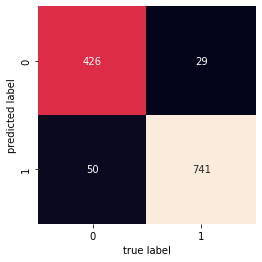

In [208]:
mat = confusion_matrix(test_output, predicted_labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Porovnanie natrénovaných klasifikátorov

Metriky z našeho vytvoreného algoritmu 1R

In [209]:
print(datas_from_classification["test_1R"]["CR"])

              precision    recall  f1-score   support

           0       0.59      0.72      0.65       476
           1       0.80      0.68      0.74       770

    accuracy                           0.70      1246
   macro avg       0.69      0.70      0.69      1246
weighted avg       0.72      0.70      0.70      1246



Metriky z našeho vytvoreného algoritmu 2R

In [210]:
print(datas_from_classification["test_2R"]["CR"])

              precision    recall  f1-score   support

           0       0.72      0.71      0.71       476
           1       0.82      0.83      0.82       770

    accuracy                           0.78      1246
   macro avg       0.77      0.77      0.77      1246
weighted avg       0.78      0.78      0.78      1246



Metriky z našeho rozhodovacieho stromu

In [211]:
print(classification_report(test_output, predicted_labels, target_names = ["0","1"]))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92       476
           1       0.94      0.96      0.95       770

    accuracy                           0.94      1246
   macro avg       0.94      0.93      0.93      1246
weighted avg       0.94      0.94      0.94      1246



Ako môžeme vidieť náš prvý algoritmus nedosiahol dobrú presnosť. Tak sme sa rozhodli v algoritme 2R použiť dva atribúty, ktoré nám ANOVA vybrala za najlepšie a presnosť sme zvýšili. Pre rozhodovací strom sme ale použili 8 atribútov (tie ktoré mali najväčší vplyv podľa ANOVY) a už nám to dalo celkom vysokú presnosť.

## 3. Optimalizácia - hyperparameter tuning (5b)

In [212]:
print('Aktuálne používané parametre v random forest:\n')
pprint(model.get_params())

Aktuálne používané parametre v random forest:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Algoritmus používa celkom veľký zoznam hyperparametrov. Podľa dokumentácie je najdôležitejšie nastavenia, počet stromov v lese (n_estimators) a počet prvkov zvažovaných pre rozdelenie v každom uzle listu (max_features). Môžeme teoreticky uvažovať, ktoré by boli doležité pre náš dataset, ale skusíme ich mechanicky prehľadať a poskúšať. 

Pokúsime sa upraviť nasledujúcu množinu hyperparametrov:
- n_estimators = počet stromov v lese
- max_features = maximálny počet prvkov zvažovaných pre rozdelenie uzla
- max_depth = maximálny počet úrovní v každom rozhodovacom strome
- min_samples_split = minimálny počet dátových bodov umiestnených v uzle pred rozdelením uzla
- min_samples_leaf = minimálny počet údajových bodov povolených v listovom uzle
- bootstrap = metóda vzorkovania údajových bodov (s výmenou alebo bez nej)

In [213]:
n_estimators = [int(x) for x in range(100,200,10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(50, 110, num = 6)]
max_depth.append(None)
min_samples_split = [4, 8]
min_samples_leaf = [2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
}

Pre každý z hore uvedených parametrov sme zvolili množinu hodnôt, v ktorých budeme hľadať tu najlepšu kombináciu.

In [214]:
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 10, cv = 5, random_state=42, n_jobs = -1)
#rf_random = GridSearchCV(estimator = model, param_grid = random_grid, cv = 52, n_jobs = -1)
rf_random.fit(df_train_class, train_output)
rf_random.best_params_

{'n_estimators': 140,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 62,
 'bootstrap': False}

Pri nastavovaní hyperparametrov sme použili aj krížovú validáciu, ktorá je 5 násobna. Tento randomized search používa defaultne StratifiedKFold. Použili sme aj grid search, ale ten dho bežal, tak sme sa rozhodli nechať randomized. Bunka vyššie nájde najlepšie nastavenie hyperparametrov. Ale počas behu programu sme našli to, že randomizes dáva vždy iné výsledky, aj keď random seed je iný. Preto sme nižšie použili parametre, ktoré sme našli ako najlepšie.

In [215]:
random_grid = {'n_estimators': 180, 
               'min_samples_split': 8, 
               'min samples_leaf': 4, 
               'max_features': 'log2', 
               'max_depth': 100, 
               'bootstrap': False}
model = RandomForestClassifier(n_estimators = rf_random.best_params_['n_estimators'],
                              min_samples_split = rf_random.best_params_['min_samples_split'],
                              min_samples_leaf = rf_random.best_params_['min_samples_leaf'],
                              max_features = rf_random.best_params_['max_features'],
                              max_depth = rf_random.best_params_['max_depth'],
                              bootstrap = rf_random.best_params_['bootstrap']
                              ).fit(df_train_class, train_output)
predicted_labels = model.predict(df_test_class)

print('Training accuracy: ',model.score(df_train_class,train_output))
print('Test Accuracy: ',model.score(df_test_class, test_output))

Training accuracy:  1.0
Test Accuracy:  0.9398073836276083


In [216]:
export_graphviz(model.estimators_[1], 
                out_file='tree2.dot', 
                feature_names=df_test_class.columns,
                class_names = ["0","1"], 
                rounded = True, proportion = False, 
                precision = 2, filled = True)

call(['dot', '-Tpng', 'tree2.dot', '-o', 'tree2.png', '-Gdpi=600'])


# Image(filename = 'tree2.png')

0

In [217]:
print(classification_report(test_output, predicted_labels, target_names = ["0","1"]))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       476
           1       0.94      0.97      0.95       770

    accuracy                           0.94      1246
   macro avg       0.94      0.93      0.94      1246
weighted avg       0.94      0.94      0.94      1246



## 4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu (5b)

In [218]:
%run "pipeline.py"

In [219]:
df = load_datasets("001/profiles.csv","001/labor.csv")
df = fix_dataset(df)

In [220]:
rules = {}
rules['outlier'] = ["drop", "mean"]
rules['scale/tranform'] = ["scaler", "transformer"]
rules['null'] = ["knn", "drop"]
rules['atributeSelect'] = ["anova", "mutual"]
rules['atributeSelectK'] = [int(x) for x in range(2,13,2)]

In [224]:
import warnings
warnings.filterwarnings('ignore')

df_train, df_test = train_test_split(df, test_size=0.15)

outlierParamIndex = 0
scaleParamIndex = 0
nullParamIndex = 0
atributeParamIndex = 0
atributeKParamIndex = 0

n_estimators = [int(x) for x in range(100,200,10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(50, 110, num = 6)]
max_depth.append(None)
min_samples_split = [4, 8]
min_samples_leaf = [2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

while outlierParamIndex < 2:
    outlierParam = rules['outlier'][outlierParamIndex]
    nullParam = rules['null'][nullParamIndex]
    atributeParam = rules['atributeSelect'][atributeParamIndex]
    atributeKParam = rules['atributeSelectK'][atributeKParamIndex]
    
    atributeKParamIndex += 1;
    if (atributeKParamIndex % 6 == 0):
        atributeKParamIndex = atributeKParamIndex % 6
        atributeParamIndex += 1;
        if (atributeParamIndex % 2 == 0):
            atributeParamIndex = atributeParamIndex % 2 
            nullParamIndex += 1;
            if (nullParamIndex % 2 == 0):
                nullParamIndex = nullParamIndex % 2 
                scaleParamIndex += 1;
                if (scaleParamIndex % 2 == 0):
                    scaleParamIndex = scaleParamIndex % 2 
                    outlierParamIndex += 1;
                    
    encoder = CustomEncoderTransformer(df.columns)
    outlier = CustomOutlierTransformer(df.columns, outlierParam)
    minmax = CustomMinMaxTransformer(df.columns, scaleParam)
    nulls = CustomNullValuesTransformer(df.columns, nullParam)
    split = InputAndOutputTransformer(df.columns)
    selector = CustomAtributeSelectiomTransformer(df.columns, atributeParam, atributeKParam)

    # trenovacia
    my_pipeline = make_pipeline(encoder, nulls, outlier, minmax, split)
    X_train, y_train = my_pipeline.fit_transform(df_train)
    X_train, y_train  = selector.transform(X_train, y_train)

    #testovacia
    my_pipeline = make_pipeline(encoder, nulls, outlier, minmax, split)
    X_test, y_test = my_pipeline.fit_transform(df_test)
    X_test, y_test  = selector.transform(X_test, y_test)
    
    model = RandomForestClassifier()
    model.n_features_in_ = atributeKParam
    
    rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 10, cv = 5, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)
    rf_random.best_params_

    print('Parametre predspracovania: ', outlierParam, " ", scaleParam, " ", nullParam, " ", atributeParam, " ", atributeKParam)
    print('Hyperparametre: {}'.format(rf_random.best_params_))
    print('Accuracy na trenovacej množine: {}'.format(rf_random.best_score_))
    print('Accuracy na testovacej množine: {}'.format(rf_random.score(X_test, y_test)))
    print()
    


KeyboardInterrupt: 